# Problem Set 5 Duplicate for BEM114 Final Project

In [14]:
import copy
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import random
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import tensorflow as tf
import warnings
import torch

# We'll suppress some warnings from tensorflow, but feel free to
# comment out this line and see some of the efficiency gains we can get!
warnings.filterwarnings("ignore")


# Note: All io_fns and model_fns start with an 'io_' and 'model_' prefix
# respectively



def fitting_returns_data(data_path,
                         io_fn,
                         model_fn,
                         seed = None,
                         print_summary = True):
    """
    Fits data to supplied model and provides returns and alpha estimates.

        Parameters:
            data_path (str): path to factor data with first column as date
                6 factors, and the last column as risk free rate
            io_fn (fn): a function to calculate input/output pairs for the
                model fit
            model_fn (fn): a function that takes in input data, output data,
                and training and testing values, and returns the strategy
                for each day, and the observed return for each day
            seed (int): if given, the seed for the model fit will be set to
                this value
            print_summary (bool): if True, then the model won't print a summary
                of the OLS fit for our strategy return.
        Returns:
            strat_df (pd.DataFrame): The weights we would give each factor
                on each day
            return_vector (list): The returns from our strategy on each day
            model_OLS (RegressionResultsWrapper): A regression calculating the
                alpha for our strategy
    """
    # if given, set the random seed
    if seed:
        set_seed(seed)

    # Load the data into a pandas DataFrame
    data = pd.read_csv(data_path)
    # Drop date and risk free rate
    data = data.iloc[:, 1:7]

    # Shift the data by one time step to create input/output pairs
    X, y = io_fn(data)

    # Split the data into training and validation sets
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2)

    # Fit the model
    strat_df, return_vector = model_fn(X, y, X_train, y_train, X_val, y_val)

    # Calculate alpha
    y_ols = sm.add_constant(y)
    model_OLS = sm.OLS(return_vector, y_ols).fit()
    if print_summary:
        print(model_OLS.summary())

    return strat_df, return_vector, model_OLS


def set_seed(seed_value):
    # Adding a fixed seed from this solution: https://stackoverflow.com/questions/32419510/how-to-get-reproducible-results-in-keras
    # 1. Set the `PYTHONHASHSEED` environment variable at a fixed value
    os.environ['PYTHONHASHSEED']=str(seed_value)

    # 2. Set the `python` built-in pseudo-random generator at a fixed value
    random.seed(seed_value)

    # 3. Set the `numpy` pseudo-random generator at a fixed value
    np.random.seed(seed_value)

    # 4. Set the `tensorflow` pseudo-random generator at a fixed value
    tf.compat.v1.set_random_seed(seed_value)
    return

def io_day_1_lag(data):
    # Create input output pairs, where the input is the previous day of data
    # and the output is the current day of data.
    X = data.shift(1).dropna().reset_index(drop=True)
    y = data.dropna().iloc[1:,:].reset_index(drop=True)
    return X, y

def io_day_1_lag_second_order_input(data):
    # Create input output pairs where input data includes second order interactions
    X, y = io_day_1_lag(data)
    cols = X.columns

    for i in range(len(cols)):
        for j in range(i+1, len(cols)):
            col_name = cols[i] + cols[j]
            col_values = X[cols[i]] * X[cols[j]]
            X[col_name] = col_values
    return X, y

def model_feed_forward(X, y, X_train, y_train, X_val, y_val):
    # Define the neural network model
    model = Sequential()
    model.add(Dense(32, activation='relu', input_shape=(X.shape[1],)))
    model.add(Dense(16, activation='relu'))
    model.add(Dense(6, activation='linear'))

    # Compile the model
    model.compile(loss='mean_squared_error', optimizer='adam')

    # Train the model, verbose = 0 means reports aren't printed
    # at the end of each epoch
    model.fit(X_train, y_train, batch_size=32, epochs=50,
              validation_data=(X_val, y_val))

    # Make predictions
    predictions = model.predict(X)

    pred_df = pd.DataFrame(predictions)

    return predictions_to_returns(pred_df, y)

def predictions_to_returns(pred_df, y):
    # Given the predictions of each factor for each day, calculate our
    # strategy for each day, and the returns for each day

    # Apply our strategy to our predictions
    strat_df = pred_df.apply(lambda row : max_predicted_factor_strat(row), axis = 1)

    # Calculate our returns
    return_vector = np.multiply(strat_df,np.asarray(y)).apply(sum, axis = 1)

    return strat_df, return_vector


def max_predicted_factor_strat(row):
    # For each day, set our strategy to be the factor with
    # the highest predicted return
    max_pred_return = max(row)
    row_list = [x == max_pred_return for x in row]
    return pd.Series(row_list)

In [31]:
data = pd.read_csv('ff6_factors_19630701_20230131.csv')
# Drop date and risk free rate
data = data.iloc[:, 1:7]

# Shift the data by one time step to create input/output pairs
X, y = io_day_1_lag(data)

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2)

x_train_tensor = torch.tensor(X_train.values).float()
y_train_tensor = torch.tensor(y_train.values).float()

x_train_tensor.shape

torch.Size([11998, 6])

## Predicting Factor returns using a BNN

In [44]:
import pyro
import pyro.distributions as dist
from pyro.nn import PyroModule, PyroSample
import torch.nn as nn
from pyro.infer import MCMC, NUTS
from pyro.infer import Predictive


class MyFirstBNN(PyroModule):
    def __init__(self, in_dim=6, out_dim=6, hid_dim=10, prior_scale=1.):
        super().__init__()

        self.activation = nn.Tanh()  # or nn.ReLU()
        self.layer1 = PyroModule[nn.Linear](in_dim, hid_dim)  # Input to hidden layer
        self.layer2 = PyroModule[nn.Linear](hid_dim, out_dim)  # Hidden to output layer

        # Set layer parameters as random variables
        self.layer1.weight = PyroSample(dist.Normal(0., prior_scale).expand([hid_dim, in_dim]).to_event(2))
        self.layer1.bias = PyroSample(dist.Normal(0., prior_scale).expand([hid_dim]).to_event(1))
        self.layer2.weight = PyroSample(dist.Normal(0., prior_scale).expand([out_dim, hid_dim]).to_event(2))
        self.layer2.bias = PyroSample(dist.Normal(0., prior_scale).expand([out_dim]).to_event(1))

    def forward(self, x, y=None):
        x = self.activation(self.layer1(x))
        mu = self.layer2(x).squeeze()
        sigma = pyro.sample("sigma", dist.Gamma(0.5, 2.0))  # Infer the response noise

        # Sampling model
        with pyro.plate("data", 6):
            obs = pyro.sample("obs", dist.Normal(mu, sigma*sigma), obs=y)
        return mu

In [76]:
# Calculate returns and alphas using BNN with 5 day lag
def model_bnn(X, y, X_train, y_train, X_val, y_val):
    # Convert data
    x_train_tensor = torch.tensor(X_train.values).float()
    y_train_tensor = torch.tensor(y_train.values).float()
    X_val_tensor = torch.tensor(X_val.values).float()
    y_val_tensor = torch.tensor(y_val.values).float()
    X_tensor = torch.tensor(X.values).float()
    y_tensor = torch.tensor(y.values).float()

    # Define the neural network model
    model = MyFirstBNN()

    # Set Pyro random seed
    pyro.set_rng_seed(42)

    # Define Hamiltonian Monte Carlo (HMC) kernel
    # NUTS = "No-U-Turn Sampler" (https://arxiv.org/abs/1111.4246), gives HMC an adaptive step size
    nuts_kernel = NUTS(model, jit_compile=True) # jit_compile=True is faster but requires PyTorch 1.6+

    # Define MCMC sampler, get 50 posterior samples
    mcmc = MCMC(nuts_kernel, num_samples=15)

    # Run MCMC
    mcmc.run(x_train_tensor, y_train_tensor)

    # Make predictions
    predictive = Predictive(model=model, posterior_samples=mcmc.get_samples())
    preds = predictive(X_tensor)
    pred_means = preds['obs'].T.detach().numpy().mean(axis=2)
    pred_stds = preds['obs'].T.detach().numpy().std(axis=2)
    pred_df = pd.DataFrame(pred_means.T)

    return predictions_to_returns(pred_df, y)
    

fitting_returns_data(
    'ff6_factors_19630701_20230131.csv',
    io_day_1_lag,
    model_bnn,
    seed = 1)

Sample: 100%|████| 30/30 [00:10,  2.85it/s, step size=1.07e-03, acc. prob=0.995]


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.197
Model:                            OLS   Adj. R-squared:                  0.197
Method:                 Least Squares   F-statistic:                     613.9
Date:                Wed, 05 Jun 2024   Prob (F-statistic):               0.00
Time:                        17:03:47   Log-Likelihood:                -12266.
No. Observations:               14998   AIC:                         2.455e+04
Df Residuals:                   14991   BIC:                         2.460e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0100      0.004      2.217      0.0

(           0      1      2      3      4      5
 0      False  False  False   True  False  False
 1       True  False  False  False  False  False
 2      False  False  False  False  False   True
 3      False  False  False   True  False  False
 4      False  False  False   True  False  False
 ...      ...    ...    ...    ...    ...    ...
 14993  False  False   True  False  False  False
 14994  False  False  False  False  False   True
 14995  False   True  False  False  False  False
 14996  False  False  False  False   True  False
 14997  False  False   True  False  False  False
 
 [14998 rows x 6 columns],
 0       -0.08
 1        0.63
 2        0.07
 3       -0.27
 4        0.15
          ... 
 14993    0.65
 14994   -1.23
 14995    0.32
 14996    0.81
 14997   -0.06
 Length: 14998, dtype: float64,
 <statsmodels.regression.linear_model.RegressionResultsWrapper at 0x2bf1b3650>)

## Question 0 - Run the Neural Net and Interpet the alpha
The following code fits a feed-forward neural net on all data, and prints a summary.
Run the code and provide an interpretation of the alpha.

```
fitting_returns_data(
    'ff6_factors_19630701_20230131.csv',
    io_day_1_lag,
    model_feed_forward);
```

**Note**: The test-train split we're employing in these model fits is faulty. We use data from the future to predict our model, so all results here have some level of overfitting. However, I separately fit the models by only using past data, and we were able to get similar results, so the results still seem robust to the potential overfitting.

### Question 0 Solution

In [4]:
COMMON_SEED = 519

# Calculate returns and alphas using feed forward neural net model
fitting_returns_data(
    'ff6_factors_19630701_20230131.csv',
    io_day_1_lag,
    model_feed_forward,
    seed = COMMON_SEED);

Epoch 1/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 740us/step - loss: 0.4640 - val_loss: 0.4482
Epoch 2/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 522us/step - loss: 0.4371 - val_loss: 0.4460
Epoch 3/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 578us/step - loss: 0.4344 - val_loss: 0.4450
Epoch 4/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 494us/step - loss: 0.4323 - val_loss: 0.4443
Epoch 5/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 469us/step - loss: 0.4308 - val_loss: 0.4441
Epoch 6/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 583us/step - loss: 0.4297 - val_loss: 0.4437
Epoch 7/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 534us/step - loss: 0.4289 - val_loss: 0.4438
Epoch 8/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 528us/step - loss: 0.4281 - val_loss: 0.4439
Epoch 9/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 503us/step - loss: 0.4274 - val_loss: 0.4441
Epoch 10/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 536us/step - loss: 0.4268 - val_loss: 0.4441
Epoch 11/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 566us/step - loss: 0.4262 - val_loss: 0.4442
Epoch 12/50
375/375 ━━━━━━━━━━

The alpha value of 0.1232 is positive and significant at the 1% level, indicating that using Neural Networks to identify relationships between the six factors is a profitable hedge fund strategy.

## Question 1 - Comparing Neural Net to OLS

### 1ai [20 points] Set a linear activation function
For the feed-forward neural net that is fit above, the `model_feed_forward` function sets up activation across hidden layers with the following code:

```
model = Sequential()
model.add(Dense(32, activation='relu', input_shape=(6,)))
model.add(Dense(16, activation='relu'))
model.add(Dense(6, activation='linear'))
```

Write a new function called `model_feed_forward_linear`, which changes the `'relu'` parameter to `'linear'`.


Calculate reults for the neural net with linear activation. How does this compare to the ReLU activation from Question 0?

### Solution 1ai

In [3]:
# Define linear feed-forward neural net based on model_feed_forward
def model_feed_forward_linear(X, y, X_train, y_train, X_val, y_val):
    # Define the neural network model
    model = Sequential()
    model.add(Dense(32, activation='linear', input_shape=(X.shape[1],)))
    model.add(Dense(16, activation='linear'))
    model.add(Dense(6, activation='linear'))

    # Compile the model
    model.compile(loss='mean_squared_error', optimizer='adam')

    # Train the model, verbose = 0 means reports aren't printed
    # at the end of each epoch
    model.fit(X_train, y_train, batch_size=32, epochs=50,
              validation_data=(X_val, y_val))

    # Make predictions
    predictions = model.predict(X)

    pred_df = pd.DataFrame(predictions)

    return predictions_to_returns(pred_df, y)

# Calculate returns and alphas from linear neural net
fitting_returns_data(
    'ff6_factors_19630701_20230131.csv',
    io_day_1_lag,
    model_feed_forward_linear,
    seed = COMMON_SEED)


Epoch 1/50
375/375 [==============================] - 2s 2ms/step - loss: 0.4409 - val_loss: 0.4450
Epoch 2/50
375/375 [==============================] - 1s 2ms/step - loss: 0.4226 - val_loss: 0.4450
Epoch 3/50
375/375 [==============================] - 1s 2ms/step - loss: 0.4217 - val_loss: 0.4446
Epoch 4/50
375/375 [==============================] - 1s 2ms/step - loss: 0.4206 - val_loss: 0.4527
Epoch 5/50
375/375 [==============================] - 1s 2ms/step - loss: 0.4213 - val_loss: 0.4448
Epoch 6/50
375/375 [==============================] - 1s 2ms/step - loss: 0.4201 - val_loss: 0.4466
Epoch 7/50
375/375 [==============================] - 1s 2ms/step - loss: 0.4205 - val_loss: 0.4462
Epoch 8/50
375/375 [==============================] - 1s 2ms/step - loss: 0.4211 - val_loss: 0.4473
Epoch 9/50
375/375 [==============================] - 1s 2ms/step - loss: 0.4197 - val_loss: 0.4479
Epoch 10/50
375/375 [==============================] - 1s 3ms/step - loss: 0.4198 - val_loss: 0.4540

(           0      1      2      3      4      5
 0       True  False  False  False  False  False
 1      False  False  False  False  False   True
 2      False  False  False  False  False   True
 3       True  False  False  False  False  False
 4      False  False  False  False   True  False
 ...      ...    ...    ...    ...    ...    ...
 14993  False  False  False  False  False   True
 14994  False  False   True  False  False  False
 14995   True  False  False  False  False  False
 14996   True  False  False  False  False  False
 14997  False  False  False  False  False   True
 
 [14998 rows x 6 columns],
 0        0.79
 1        0.41
 2        0.07
 3       -0.63
 4       -0.01
          ... 
 14993    0.14
 14994    0.01
 14995    0.36
 14996   -1.38
 14997   -0.70
 Length: 14998, dtype: float64,
 <statsmodels.regression.linear_model.RegressionResultsWrapper at 0x7b0106446ef0>)

The ReLU alpha of 0.1232 is higher than the linear alpha of 0.0950, while both are statistically significant at the 1% level. This indicates that the ReLU activation function better supports neural networks to identify profitable relationships between factors, though we may need more in-depth experiments to conclude this convincingly.

### 1aii [10 points] Compare with linear model

The following code defines a function called `model_linear_fit`, which fits a linear model on y_train and X_train and outputs the predicted return given `X`, called `pred_df`. The function then calculates the  returns of the linear model by running `predictions_to_returns(pred_df, y)`.

Since the neural net is only fitting on linear relationships, we should see similar results across the linear neural net and the linear OLS model here.

Calculate reults for the linear model below. How does the alpha compare to the linear neural net?  

### Solution 1aii

In [4]:
# Define linear OLS model
## Linear Model Fit
def model_linear_fit(X, y, X_train, y_train, X_val, y_val):
    model_OLS = sm.OLS(y_train, X_train).fit()
    # Make predictions
    predictions = model_OLS.predict(X)

    pred_df = pd.DataFrame(predictions)

    return predictions_to_returns(pred_df, y)

# Calculate returns and alphas using linear OLS model
fitting_returns_data(
    'ff6_factors_19630701_20230131.csv',
    io_day_1_lag,
    model_linear_fit,
    seed = COMMON_SEED)


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.127
Model:                            OLS   Adj. R-squared:                  0.127
Method:                 Least Squares   F-statistic:                     363.2
Date:                Sun, 19 May 2024   Prob (F-statistic):               0.00
Time:                        03:33:44   Log-Likelihood:                -15513.
No. Observations:               14998   AIC:                         3.104e+04
Df Residuals:                   14991   BIC:                         3.109e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0904      0.006     16.202      0.0

(           0      1      2      3      4      5
 0       True  False  False  False  False  False
 1      False  False  False  False  False   True
 2      False  False  False  False  False   True
 3      False   True  False  False  False  False
 4      False  False  False  False   True  False
 ...      ...    ...    ...    ...    ...    ...
 14993  False  False  False  False  False   True
 14994  False  False   True  False  False  False
 14995   True  False  False  False  False  False
 14996   True  False  False  False  False  False
 14997  False  False  False  False  False   True
 
 [14998 rows x 6 columns],
 0        0.79
 1        0.41
 2        0.07
 3        0.07
 4       -0.01
          ... 
 14993    0.14
 14994    0.01
 14995    0.36
 14996   -1.38
 14997   -0.70
 Length: 14998, dtype: float64,
 <statsmodels.regression.linear_model.RegressionResultsWrapper at 0x7b0109f955a0>)

The linear model alpha of 0.0904 is very similar the neural network model alpha of 0.0950, which is as expected. Both are statistically significant at the 1% level.

### 1b [20 points] Include Interaction Terms
Linear models don't account for any interaction effects. In order to account for an interaction we can add input variables that give the product of factor returns on each day. This would be analogous to adding a interaction term to a linear model.

Using the io_ function `io_day_1_lag_second_order_input`, and your `model_linear_fit` function, calculate returns while including second order inputs.

Write a new io_ function `io_day_lag_third_order_input`, to also include third order fits in your input data.

How do these models compare to the ReLU alpha?


### Solution 1b

In [5]:
# Calculate returns and alphas using linear OLS model
fitting_returns_data(
    'ff6_factors_19630701_20230131.csv',
    io_day_1_lag_second_order_input,
    model_linear_fit,
    seed = COMMON_SEED)

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.164
Model:                            OLS   Adj. R-squared:                  0.163
Method:                 Least Squares   F-statistic:                     489.2
Date:                Sun, 19 May 2024   Prob (F-statistic):               0.00
Time:                        03:33:49   Log-Likelihood:                -16116.
No. Observations:               14998   AIC:                         3.225e+04
Df Residuals:                   14991   BIC:                         3.230e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0965      0.006     16.615      0.0

(           0      1      2      3      4      5
 0       True  False  False  False  False  False
 1      False  False  False  False  False   True
 2      False  False  False  False  False   True
 3       True  False  False  False  False  False
 4      False  False  False  False   True  False
 ...      ...    ...    ...    ...    ...    ...
 14993  False  False  False  False  False   True
 14994  False  False   True  False  False  False
 14995   True  False  False  False  False  False
 14996   True  False  False  False  False  False
 14997  False  False  False  False  False   True
 
 [14998 rows x 6 columns],
 0        0.79
 1        0.41
 2        0.07
 3       -0.63
 4       -0.01
          ... 
 14993    0.14
 14994    0.01
 14995    0.36
 14996   -1.38
 14997   -0.70
 Length: 14998, dtype: float64,
 <statsmodels.regression.linear_model.RegressionResultsWrapper at 0x7b0109f95ba0>)

In [6]:
# Create input output pairs where input data includes second order interactions

# This is actually third order as described in the question. The outputs are not
# similar to the sanity checks that professor Sinclair wrote for us.
# def io_day_lag_third_order_input(data):
#     X, y = io_day_1_lag(data)
#     cols = X.columns

#     X, y = io_day_1_lag_second_order_input(data)

#     for i in range(len(cols)):
#         for j in range(i+1, len(cols)):
#           for k in range(j+1, len(cols)):
#             col_name = cols[i] + cols[j] + cols[k]
#             col_values = X[cols[i]] * X[cols[j]] * X[cols[k]]
#             X[col_name] = col_values

#     return X, y

# This is fourth order. The outputs agree very closely with professor Sinclair's
# sanity checks.
def io_day_lag_third_order_input(data):
    # Create input output pairs where input data includes second order interactions
    X, y = io_day_1_lag_second_order_input(data)
    cols = X.columns

    for i in range(len(cols)):
        for j in range(i+1, len(cols)):
            col_name = cols[i] + cols[j]
            col_values = X[cols[i]] * X[cols[j]]
            X[col_name] = col_values

    return X, y

# Calculate returns and alphas using third order interactions
fitting_returns_data(
    'ff6_factors_19630701_20230131.csv',
    io_day_lag_third_order_input,
    model_linear_fit,
    seed = COMMON_SEED)

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.120
Model:                            OLS   Adj. R-squared:                  0.120
Method:                 Least Squares   F-statistic:                     340.7
Date:                Sun, 19 May 2024   Prob (F-statistic):               0.00
Time:                        03:33:53   Log-Likelihood:                -16045.
No. Observations:               14998   AIC:                         3.210e+04
Df Residuals:                   14991   BIC:                         3.216e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1240      0.006     21.447      0.0

(           0      1      2      3      4      5
 0      False  False  False  False   True  False
 1      False  False  False  False  False   True
 2      False  False  False  False  False   True
 3       True  False  False  False  False  False
 4      False  False  False  False   True  False
 ...      ...    ...    ...    ...    ...    ...
 14993  False  False  False  False  False   True
 14994  False  False   True  False  False  False
 14995  False   True  False  False  False  False
 14996  False   True  False  False  False  False
 14997  False  False  False  False  False   True
 
 [14998 rows x 6 columns],
 0       -0.21
 1        0.41
 2        0.07
 3       -0.63
 4       -0.01
          ... 
 14993    0.14
 14994    0.01
 14995    0.32
 14996    0.05
 14997   -0.70
 Length: 14998, dtype: float64,
 <statsmodels.regression.linear_model.RegressionResultsWrapper at 0x7b0109f95390>)

The second order linear model has an alpha of 0.0965, which is lower than the ReLU alpha of 0.1232, but is significant at the 1% level. On the other hand, the third order linear model that we implemented as fourth order to be similar to the desired output has alpha of 0.1240, which is very similar to the ReLU alpha. It is also statistically significant at the 1% level.

## Question 2 - Adding Time Lag Parameters
### 2 [25 points] Lag Time Parameters
Our current neural net only uses the past 1 day of data. For time series data, including more lag days can be useful. For example, if a factor return is high for 2 consecutive days, that may be more informative than just knowing that the return was only high for the previous day.

In this question, we will simply add a new column to our input data for each lagged data. This is analogous to an AutoRegressive Model, which is a popular financial engineering tool, [see this textbook](https://link.springer.com/book/10.1007/978-1-4939-2614-5). In the Neural Net literature, a Recurrent Neural Net is a common tool for more directly accounting for time lagged data directly in the neural net architecture, but the lagged model gets us a good amount of the way there!

Starting from the `io_day_1_lag` function write an `io_day_5_lag` function, which adds to the input dataframe 5 days of lagged data per factor. This will mean your input data will now have 6*5 = 30 columns instead of 6 columns.

When complete, run the following and compare results to the original ReLU model from Question 0. How do the results compare? Should we continue to to pursue incorporating lag effects in our analysis of this data?

```
fitting_returns_data(
    'ff6_factors_19630701_20230131.csv',
    io_day_5_lag,
    model_feed_forward);
 ```

 ### Question 2 Solution

In [7]:
def io_day_5_lag(data):
    X = data.shift(1).add_suffix('_lag1')
    for i in range(2, 6):
        shifted_data = data.shift(i).add_suffix('_lag{}'.format(i))
        X = pd.concat([X, shifted_data], axis=1)
    X = X.dropna().reset_index(drop=True)
    y = data.iloc[5:,:].reset_index(drop=True)
    return X, y

# Calculate returns and alphas using the feed forward neural net with
# five day lagged input variables.
fitting_returns_data(
    'ff6_factors_19630701_20230131.csv',
    io_day_5_lag,
    model_feed_forward,
    seed = COMMON_SEED)

Epoch 1/50
375/375 [==============================] - 2s 3ms/step - loss: 0.4547 - val_loss: 0.4522
Epoch 2/50
375/375 [==============================] - 1s 2ms/step - loss: 0.4241 - val_loss: 0.4499
Epoch 3/50
375/375 [==============================] - 1s 2ms/step - loss: 0.4196 - val_loss: 0.4489
Epoch 4/50
375/375 [==============================] - 1s 2ms/step - loss: 0.4159 - val_loss: 0.4481
Epoch 5/50
375/375 [==============================] - 1s 2ms/step - loss: 0.4123 - val_loss: 0.4488
Epoch 6/50
375/375 [==============================] - 1s 3ms/step - loss: 0.4085 - val_loss: 0.4482
Epoch 7/50
375/375 [==============================] - 1s 3ms/step - loss: 0.4051 - val_loss: 0.4479
Epoch 8/50
375/375 [==============================] - 1s 3ms/step - loss: 0.4017 - val_loss: 0.4482
Epoch 9/50
375/375 [==============================] - 1s 3ms/step - loss: 0.3992 - val_loss: 0.4505
Epoch 10/50
375/375 [==============================] - 1s 2ms/step - loss: 0.3956 - val_loss: 0.4498

(           0      1      2      3      4      5
 0       True  False  False  False  False  False
 1      False  False  False  False  False   True
 2       True  False  False  False  False  False
 3       True  False  False  False  False  False
 4       True  False  False  False  False  False
 ...      ...    ...    ...    ...    ...    ...
 14989  False  False   True  False  False  False
 14990  False  False  False  False  False   True
 14991   True  False  False  False  False  False
 14992   True  False  False  False  False  False
 14993  False  False  False  False  False   True
 
 [14994 rows x 6 columns],
 0        0.45
 1        0.16
 2       -0.16
 3       -0.12
 4       -0.62
          ... 
 14989    0.65
 14990   -1.23
 14991    0.36
 14992   -1.38
 14993   -0.70
 Length: 14994, dtype: float64,
 <statsmodels.regression.linear_model.RegressionResultsWrapper at 0x7b01060fe170>)

The 5 day lag feed-forward neural network model has an alpha of 0.1574, which is larger than the 1 day lag ReLU model alpha of 0.1232 and statistically significant at the 1% level. This indicates that we should continue to incorporate lag effects into our models, and supports the intuitive notion that giving the model factor information from days earlier than the previous day will improve the performance.

## Question 3 - Investigating Potentials for P-Hacking
### 3 [25 points] Randomness in Alphas

Neural  nets are fit via a Stochastic Gradient Descent. This implies that there is inherent randomness in any fit of the model. One good way to account for this noise in your model is to refit the model multiple times and observe the distribution. It's more accurate to report the median or mean of these estimates, although it can be hard to tell if a paper/report has cherry-picked the best result in this way.

Using the `io_day_1_lag`, and `model_feed_forward` settings, rerun the model 100 times and get a distribution for the alpha given. (You can use the `seed` parameter in the `fitting_returns_data` function if you want to be able to reproduce a given high return.)

Set `print_summary = False` in `fitting_returns_data` in order to avoid large amounts of output.

What's the highest return you could get if you were to ignore the importance of the robustness of a model result? What would be a downside of reporting a result like this?

Note: running the model 100 times may take awhile (over an hour on Google Colab). Debug your code before attempting the 100 cycles.

### Question 3 Solution


In [8]:
# Rerun model 100 times
num_reruns = 100
alphas = []

np.random.seed(519)
seeds = np.random.randint(9999, size=num_reruns)

for i in range(num_reruns):
    model_fit = fitting_returns_data(
        'ff6_factors_19630701_20230131.csv',
        io_day_1_lag,
        model_feed_forward,
        seed = seeds[i],
        print_summary = False)[2]
    alphas.append(model_fit.params[0])
    if i%10 == 0:
        print(i)

Streaming output truncated to the last 5000 lines.
Epoch 29/50
375/375 [==============================] - 1s 3ms/step - loss: 0.4060 - val_loss: 0.4426
Epoch 30/50
375/375 [==============================] - 1s 3ms/step - loss: 0.4059 - val_loss: 0.4442
Epoch 31/50
375/375 [==============================] - 1s 3ms/step - loss: 0.4055 - val_loss: 0.4429
Epoch 32/50
375/375 [==============================] - 1s 3ms/step - loss: 0.4054 - val_loss: 0.4430
Epoch 33/50
375/375 [==============================] - 1s 3ms/step - loss: 0.4050 - val_loss: 0.4445
Epoch 34/50
375/375 [==============================] - 1s 3ms/step - loss: 0.4049 - val_loss: 0.4428
Epoch 35/50
375/375 [==============================] - 1s 3ms/step - loss: 0.4041 - val_loss: 0.4441
Epoch 36/50
375/375 [==============================] - 1s 3ms/step - loss: 0.4047 - val_loss: 0.4440
Epoch 37/50
375/375 [==============================] - 1s 4ms/step - loss: 0.4037 - val_loss: 0.4435
Epoch 38/50
375/375 [===================

Highest return if we ignore robustness: 0.13485969142097237


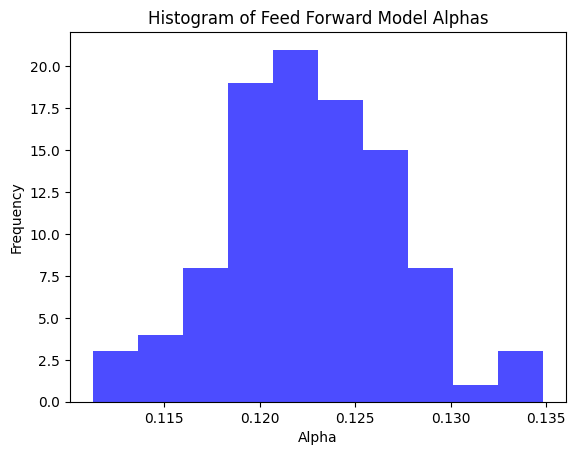

In [9]:
print(f'Highest return if we ignore robustness: {max(alphas)}')

# Create the histogram
plt.hist(alphas, bins=10, alpha=0.7, color='blue')

# Add title and labels
plt.title('Histogram of Feed Forward Model Alphas')
plt.xlabel('Alpha')
plt.ylabel('Frequency')

# Show the plot
plt.show()

The highest alpha we could get if we ignore robustness is 0.135. Simply taking the highest alpha from a bunch of random trials would cause us to falsely believe our model is better than it is. This will lead to the model's average-case performance with real money on the market being far worse than our backtest expectations, which were based on a favorable random condition.